# 🎨 Data Designer Tutorial: Generating Images

#### 📚 What you'll learn

This notebook shows how to generate synthetic image data with Data Designer using image-generation models.

- 🖼️ **Image generation columns**: Add columns that produce images from text prompts
- 📝 **Jinja2 prompts**: Drive diversity by referencing other columns in your prompt template
- 💾 **Preview vs create**: Preview stores base64 in the dataframe; create saves images to disk and stores paths

Data Designer supports both **diffusion** (e.g. DALL·E, Stable Diffusion, Imagen) and **autoregressive** (e.g. Gemini image, GPT image) models.

> **Prerequisites**: This tutorial uses [OpenRouter](https://openrouter.ai) with the Flux 2 Pro image model. Set `OPENROUTER_API_KEY` in your environment before running.

If this is your first time using Data Designer, we recommend starting with the [first notebook](https://nvidia-nemo.github.io/DataDesigner/latest/notebooks/1-the-basics/) in this tutorial series.


### 📦 Import Data Designer

- `data_designer.config` provides the configuration API.
- `DataDesigner` is the main interface for generation.


In [1]:
from IPython.display import Image as IPImage
from IPython.display import display

import data_designer.config as dd
from data_designer.interface import DataDesigner

### ⚙️ Initialize the Data Designer interface

We initialize Data Designer without arguments here—the image model is configured explicitly in the next cell. No default text model is needed for this tutorial.


In [2]:
data_designer = DataDesigner()

### 🎛️ Define an image-generation model

- Use `ImageInferenceParams` so Data Designer treats this model as an image generator.
- Image options (size, quality, aspect ratio, etc.) are model-specific; pass them via `extra_body`.


In [3]:
MODEL_PROVIDER = "openrouter"
MODEL_ID = "black-forest-labs/flux.2-pro"
MODEL_ALIAS = "image-model"

model_configs = [
    dd.ModelConfig(
        alias=MODEL_ALIAS,
        model=MODEL_ID,
        provider=MODEL_PROVIDER,
        inference_parameters=dd.ImageInferenceParams(
            extra_body={"height": 512, "width": 512},
        ),
    )
]

### 🏗️ Build the config: samplers + image column

We'll generate diverse **dog portrait** images: sampler columns drive subject (breed), age, style, look direction, and emotion. The image-generation column uses a Jinja2 prompt that references all of them.


In [4]:
config_builder = dd.DataDesignerConfigBuilder(model_configs=model_configs)

config_builder.add_column(
    dd.SamplerColumnConfig(
        name="style",
        sampler_type=dd.SamplerType.CATEGORY,
        params=dd.CategorySamplerParams(
            values=[
                "photorealistic",
                "oil painting",
                "watercolor",
                "digital art",
                "sketch",
                "anime",
            ],
        ),
    )
)

config_builder.add_column(
    dd.SamplerColumnConfig(
        name="dog_breed",
        sampler_type=dd.SamplerType.CATEGORY,
        params=dd.CategorySamplerParams(
            values=[
                "a Golden Retriever",
                "a German Shepherd",
                "a Labrador Retriever",
                "a Bulldog",
                "a Beagle",
                "a Poodle",
                "a Corgi",
                "a Siberian Husky",
                "a Dalmatian",
                "a Yorkshire Terrier",
                "a Boxer",
                "a Dachshund",
                "a Doberman Pinscher",
                "a Shih Tzu",
                "a Chihuahua",
                "a Border Collie",
                "an Australian Shepherd",
                "a Cocker Spaniel",
                "a Maltese",
                "a Pomeranian",
                "a Saint Bernard",
                "a Great Dane",
                "an Akita",
                "a Samoyed",
                "a Boston Terrier",
            ],
        ),
    )
)

config_builder.add_column(
    dd.SamplerColumnConfig(
        name="cat_breed",
        sampler_type=dd.SamplerType.CATEGORY,
        params=dd.CategorySamplerParams(
            values=[
                "a Persian",
                "a Maine Coon",
                "a Siamese",
                "a Ragdoll",
                "a Bengal",
                "an Abyssinian",
                "a British Shorthair",
                "a Sphynx",
                "a Scottish Fold",
                "a Russian Blue",
                "a Birman",
                "an Oriental Shorthair",
                "a Norwegian Forest Cat",
                "a Devon Rex",
                "a Burmese",
                "an Egyptian Mau",
                "a Tonkinese",
                "a Himalayan",
                "a Savannah",
                "a Chartreux",
                "a Somali",
                "a Manx",
                "a Turkish Angora",
                "a Balinese",
                "an American Shorthair",
            ],
        ),
    )
)

config_builder.add_column(
    dd.SamplerColumnConfig(
        name="dog_age",
        sampler_type=dd.SamplerType.CATEGORY,
        params=dd.CategorySamplerParams(
            values=["1-3", "3-6", "6-9", "9-12", "12-15"],
        ),
    )
)

config_builder.add_column(
    dd.SamplerColumnConfig(
        name="cat_age",
        sampler_type=dd.SamplerType.CATEGORY,
        params=dd.CategorySamplerParams(
            values=["1-3", "3-6", "6-9", "9-12", "12-18"],
        ),
    )
)

config_builder.add_column(
    dd.SamplerColumnConfig(
        name="dog_look_direction",
        sampler_type=dd.SamplerType.CATEGORY,
        params=dd.CategorySamplerParams(
            values=["left", "right", "front", "up", "down"],
        ),
    )
)

config_builder.add_column(
    dd.SamplerColumnConfig(
        name="cat_look_direction",
        sampler_type=dd.SamplerType.CATEGORY,
        params=dd.CategorySamplerParams(
            values=["left", "right", "front", "up", "down"],
        ),
    )
)

config_builder.add_column(
    dd.SamplerColumnConfig(
        name="dog_emotion",
        sampler_type=dd.SamplerType.CATEGORY,
        params=dd.CategorySamplerParams(
            values=["happy", "curious", "serious", "sleepy", "excited"],
        ),
    )
)

config_builder.add_column(
    dd.SamplerColumnConfig(
        name="cat_emotion",
        sampler_type=dd.SamplerType.CATEGORY,
        params=dd.CategorySamplerParams(
            values=["aloof", "curious", "content", "sleepy", "playful"],
        ),
    )
)

config_builder.add_column(
    dd.ImageColumnConfig(
        name="generated_image",
        prompt=(
            """
A {{ style }} family pet portrait of a {{ dog_breed }} dog of {{ dog_age }} years old looking {{dog_look_direction}} with an {{ dog_emotion }} expression and
{{ cat_breed }} cat of {{ cat_age }} years old looking {{ cat_look_direction }} with an {{ cat_emotion }} expression in the background. Both subjects should be in focus.
        """
        ),
        model_alias=MODEL_ALIAS,
    )
)

data_designer.validate(config_builder)

[16:32:12] [INFO] ✅ Validation passed


### 🔁 Preview: images as base64

In **preview** mode, generated images are stored as base64 strings in the dataframe. Run the next cell to step through each record (images are shown in the sample record display, but only in a notebook environment).


In [5]:
preview = data_designer.preview(config_builder, num_records=2)

[16:32:12] [INFO] 🔁 Preview generation in progress


[16:32:12] [INFO] ✅ Validation passed


[16:32:12] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph


[16:32:12] [INFO] 🩺 Running health checks for models...


[16:32:12] [INFO]   |-- 👀 Checking 'black-forest-labs/flux.2-pro' in provider named 'openrouter' for model alias 'image-model'...


[16:32:22] [INFO]   |-- ✅ Passed!


[16:32:22] [INFO] 🎲 Preparing samplers to generate 2 records across 9 columns


[16:32:22] [INFO] 🖼️ image model config for column 'generated_image'


[16:32:22] [INFO]   |-- model: 'black-forest-labs/flux.2-pro'


[16:32:22] [INFO]   |-- model alias: 'image-model'


[16:32:22] [INFO]   |-- model provider: 'openrouter'


[16:32:22] [INFO]   |-- inference parameters:


[16:32:22] [INFO]   |  |-- generation_type=image


[16:32:22] [INFO]   |  |-- max_parallel_requests=4


[16:32:22] [INFO]   |  |-- extra_body={'height': 512, 'width': 512}


[16:32:22] [INFO] ⚡️ Processing image column 'generated_image' with 4 concurrent workers


[16:32:22] [INFO] ⏱️ image column 'generated_image' will report progress after each record


[16:32:37] [INFO]   |-- ⛅ image column 'generated_image' progress: 1/2 (50%) complete, 1 ok, 0 failed, 0.07 rec/s, eta 15.0s


[16:32:39] [INFO]   |-- ☀️ image column 'generated_image' progress: 2/2 (100%) complete, 2 ok, 0 failed, 0.12 rec/s, eta 0.0s


[16:32:39] [INFO] 📊 Model usage summary:


[16:32:39] [INFO]   |-- model: black-forest-labs/flux.2-pro


[16:32:39] [INFO]   |-- tokens: input=0, output=0, total=0, tps=0


[16:32:39] [INFO]   |-- requests: success=2, failed=0, total=2, rpm=6


[16:32:39] [INFO]   |-- images: total=2


[16:32:39] [INFO] 📐 Measuring dataset column statistics:


[16:32:39] [INFO]   |-- 🎲 column: 'style'


[16:32:39] [INFO]   |-- 🎲 column: 'dog_breed'


[16:32:39] [INFO]   |-- 🎲 column: 'cat_breed'


[16:32:39] [INFO]   |-- 🎲 column: 'dog_age'


[16:32:39] [INFO]   |-- 🎲 column: 'cat_age'


[16:32:39] [INFO]   |-- 🎲 column: 'dog_look_direction'


[16:32:39] [INFO]   |-- 🎲 column: 'cat_look_direction'


[16:32:39] [INFO]   |-- 🎲 column: 'dog_emotion'


[16:32:39] [INFO]   |-- 🎲 column: 'cat_emotion'


[16:32:39] [INFO]   |-- 🖼️ column: 'generated_image'


[16:32:39] [INFO] 🍾 Preview complete!


                                              Generated Columns                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                                                     ┃ Value                                           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ style                                                    │ digital art                                     │
├──────────────────────────────────────────────────────────┼─────────────────────────────────────────────────┤
│ dog_breed                                                │ a Saint Bernard                                 │
├──────────────────────────────────────────────────────────┼─────────────────────────────────────────────────┤
│ cat_breed                                                │ a Tonkinese                                     │
├──────────────────────────────────────────────────────────┼─────────────────────────────────────────────────┤
│ dog_age                                                  │ 9-12                                            │
├──────────────────────────────────────────────────────────┼─────────────────────────────────────────────────┤
│ cat_age                                                  │ 9-12                                            │
├──────────────────────────────────────────────────────────┼─────────────────────────────────────────────────┤
│ dog_look_direction                                       │ front                                           │
├──────────────────────────────────────────────────────────┼─────────────────────────────────────────────────┤
│ cat_look_direction                                       │ right                                           │
├──────────────────────────────────────────────────────────┼─────────────────────────────────────────────────┤
│ dog_emotion                                              │ curious                                         │
├──────────────────────────────────────────────────────────┼─────────────────────────────────────────────────┤
│ cat_emotion                                              │ aloof                                           │
└──────────────────────────────────────────────────────────┴─────────────────────────────────────────────────┘
                                                                                                              
                                                                                                              
                                                    Images                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                                   ┃ Preview                                                           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ generated_image                        │ [0] <base64, 1724572 chars>                                       │
└────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘
                                                                                                              
                                                  [index: 0]


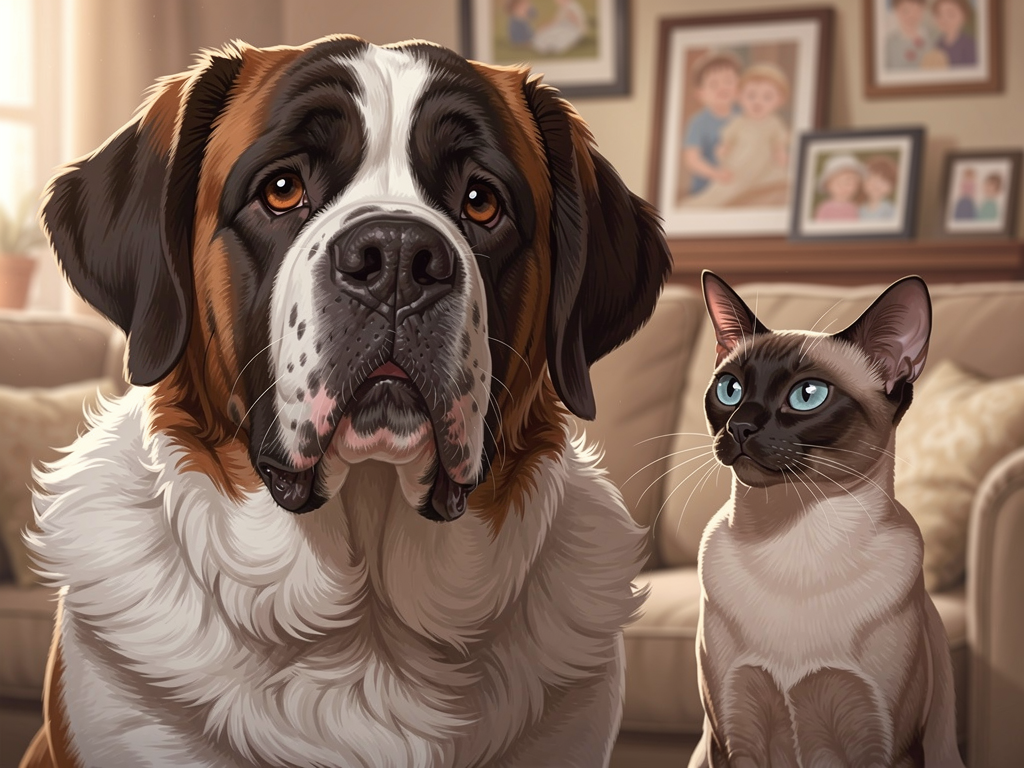

                                              Generated Columns                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                                                    ┃ Value                                            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ style                                                   │ anime                                            │
├─────────────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ dog_breed                                               │ a Siberian Husky                                 │
├─────────────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ cat_breed                                               │ a Birman                                         │
├─────────────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ dog_age                                                 │ 6-9                                              │
├─────────────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ cat_age                                                 │ 12-18                                            │
├─────────────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ dog_look_direction                                      │ up                                               │
├─────────────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ cat_look_direction                                      │ right                                            │
├─────────────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ dog_emotion                                             │ sleepy                                           │
├─────────────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ cat_emotion                                             │ aloof                                            │
└─────────────────────────────────────────────────────────┴──────────────────────────────────────────────────┘
                                                                                                              
                                                                                                              
                                                    Images                                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                                   ┃ Preview                                                           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ generated_image                        │ [0] <base64, 1407220 chars>                                       │
└────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘
                                                                                                              
                                                  [index: 1]


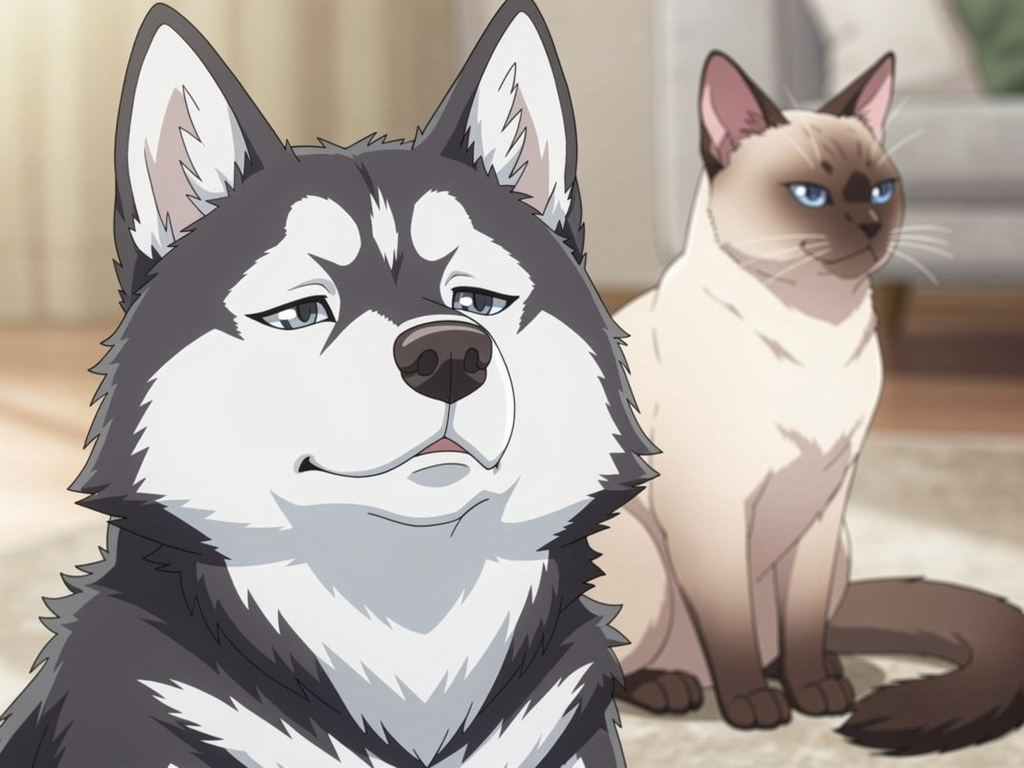

In [6]:
for i in range(len(preview.dataset)):
    preview.display_sample_record()

In [7]:
preview.dataset

style         dog_breed    cat_breed dog_age cat_age  \
0  digital art   a Saint Bernard  a Tonkinese    9-12    9-12   
1        anime  a Siberian Husky     a Birman     6-9   12-18   

  dog_look_direction cat_look_direction dog_emotion cat_emotion  \
0              front              right     curious       aloof   
1                 up              right      sleepy       aloof   

                                     generated_image  
0  [iVBORw0KGgoAAAANSUhEUgAABAAAAAMACAIAAAA12IJaA...  
1  [iVBORw0KGgoAAAANSUhEUgAABAAAAAMACAIAAAA12IJaA...

### 🆙 Create: images saved to disk

In **create** mode, images are written to an `images/` folder with UUID filenames; the dataframe stores relative paths (e.g. `images/1d16b6e2-562f-4f51-91e5-baaa999ea916.png`).


In [8]:
results = data_designer.create(config_builder, num_records=2, dataset_name="tutorial-5-images")

[16:32:39] [INFO] 🎨 Creating Data Designer dataset


[16:32:39] [INFO] ✅ Validation passed


[16:32:39] [INFO] ⛓️ Sorting column configs into a Directed Acyclic Graph


[16:32:39] [INFO] 🩺 Running health checks for models...


[16:32:39] [INFO]   |-- 👀 Checking 'black-forest-labs/flux.2-pro' in provider named 'openrouter' for model alias 'image-model'...


[16:32:49] [INFO]   |-- ✅ Passed!


[16:32:49] [INFO] ⏳ Processing batch 1 of 1


[16:32:49] [INFO] 🎲 Preparing samplers to generate 2 records across 9 columns


[16:32:49] [INFO] 🖼️ image model config for column 'generated_image'


[16:32:49] [INFO]   |-- model: 'black-forest-labs/flux.2-pro'


[16:32:49] [INFO]   |-- model alias: 'image-model'


[16:32:49] [INFO]   |-- model provider: 'openrouter'


[16:32:49] [INFO]   |-- inference parameters:


[16:32:49] [INFO]   |  |-- generation_type=image


[16:32:49] [INFO]   |  |-- max_parallel_requests=4


[16:32:49] [INFO]   |  |-- extra_body={'height': 512, 'width': 512}


[16:32:49] [INFO] ⚡️ Processing image column 'generated_image' with 4 concurrent workers


[16:32:49] [INFO] ⏱️ image column 'generated_image' will report progress after each record


[16:33:02] [INFO]   |-- 🌗 image column 'generated_image' progress: 1/2 (50%) complete, 1 ok, 0 failed, 0.07 rec/s, eta 13.4s


[16:33:06] [INFO]   |-- 🌕 image column 'generated_image' progress: 2/2 (100%) complete, 2 ok, 0 failed, 0.12 rec/s, eta 0.0s


[16:33:06] [INFO] 📊 Model usage summary:


[16:33:06] [INFO]   |-- model: black-forest-labs/flux.2-pro


[16:33:06] [INFO]   |-- tokens: input=0, output=0, total=0, tps=0


[16:33:06] [INFO]   |-- requests: success=2, failed=0, total=2, rpm=6


[16:33:06] [INFO]   |-- images: total=2


[16:33:06] [INFO] 📐 Measuring dataset column statistics:


[16:33:06] [INFO]   |-- 🎲 column: 'style'


[16:33:06] [INFO]   |-- 🎲 column: 'dog_breed'


[16:33:06] [INFO]   |-- 🎲 column: 'cat_breed'


[16:33:06] [INFO]   |-- 🎲 column: 'dog_age'


[16:33:06] [INFO]   |-- 🎲 column: 'cat_age'


[16:33:06] [INFO]   |-- 🎲 column: 'dog_look_direction'


[16:33:06] [INFO]   |-- 🎲 column: 'cat_look_direction'


[16:33:06] [INFO]   |-- 🎲 column: 'dog_emotion'


[16:33:06] [INFO]   |-- 🎲 column: 'cat_emotion'


[16:33:06] [INFO]   |-- 🖼️ column: 'generated_image'


In [9]:
dataset = results.load_dataset()
dataset.head()

style   dog_breed   cat_breed dog_age cat_age dog_look_direction  \
0           anime  a Shih Tzu   a Siamese     6-9   12-18               left   
1  photorealistic   a Samoyed  a Balinese     6-9     1-3                 up   

  cat_look_direction dog_emotion cat_emotion  \
0               left      sleepy     playful   
1               left     serious      sleepy   

                                     generated_image  
0  ['images/generated_image/a3deaece-b354-437a-99...  
1  ['images/generated_image/fd835fdf-68a2-4180-93...

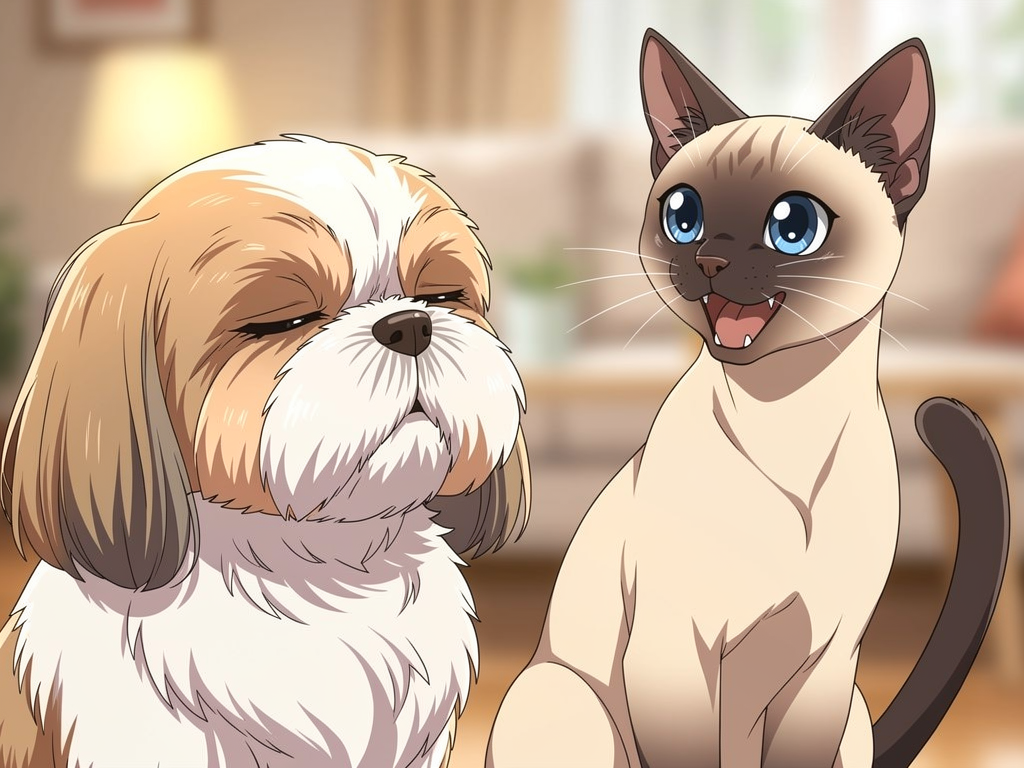

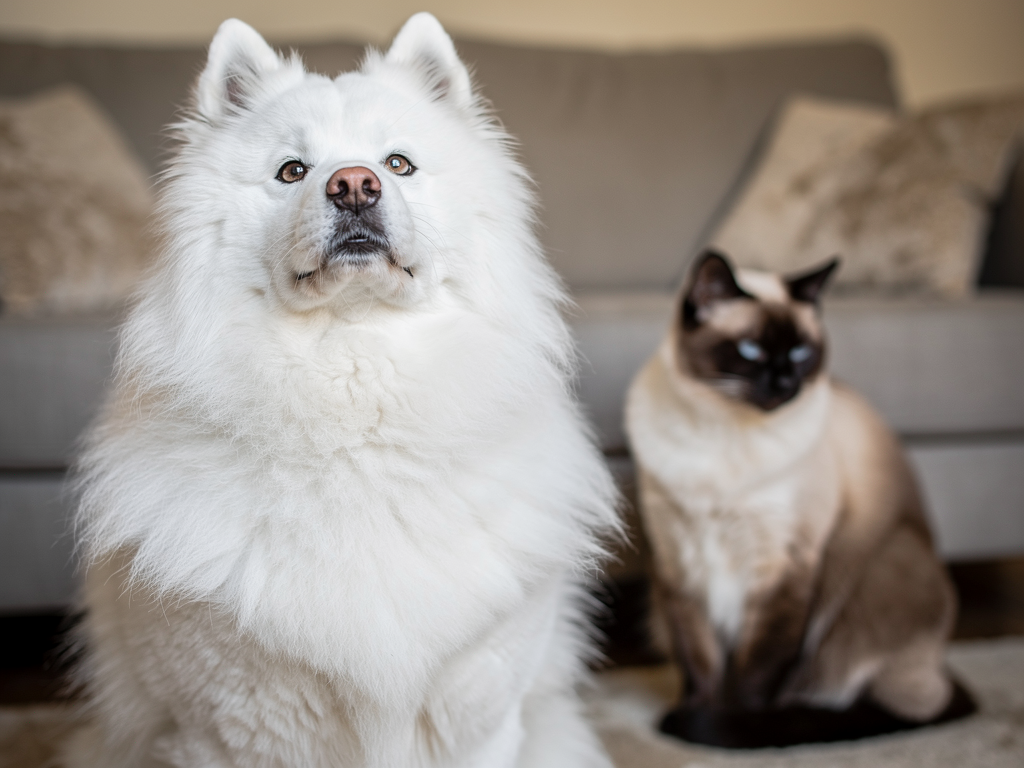

In [10]:
# Display all images from the created dataset. Paths are relative to the artifact output directory.
for index, row in dataset.iterrows():
    path_or_list = row.get("generated_image")
    if path_or_list is not None:
        paths = path_or_list if not isinstance(path_or_list, str) else [path_or_list]
        for path in paths:
            full_path = results.artifact_storage.base_dataset_path / path
            display(IPImage(filename=str(full_path)))

## ⏭️ Next steps

- [The basics](https://nvidia-nemo.github.io/DataDesigner/latest/notebooks/1-the-basics/): samplers and LLM text columns
- [Structured outputs and Jinja](https://nvidia-nemo.github.io/DataDesigner/latest/notebooks/2-structured-outputs-and-jinja-expressions/)
- [Seeding with a dataset](https://nvidia-nemo.github.io/DataDesigner/latest/notebooks/3-seeding-with-a-dataset/)
- [Providing images as context](https://nvidia-nemo.github.io/DataDesigner/latest/notebooks/4-providing-images-as-context/)
- [Image-to-image editing](https://nvidia-nemo.github.io/DataDesigner/latest/notebooks/6-editing-images-with-image-context/): edit existing images with seed datasets
